<a href="https://colab.research.google.com/github/bartlomiejsiusta/mgu/blob/main/MGU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras
!pip install foolbox==3.3.1
import foolbox
import eagerpy as ep


In [19]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train.astype(np.float32)
x_test.astype(np.float32)
x_train = x_train/255.0
x_test = x_test/255.0


# dzielenie danych treningowych na treningowe i walidacyjne
(x_train, x_valid) = x_train[5000:], x_train[:5000] 
(y_train, y_valid) = y_train[5000:], y_train[:5000]


# one hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
#y_test = keras.utils.to_categorical(y_test, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)
#plt.imshow(x_train[2])


print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_valid shape:", x_valid.shape, "y_valid shape:", y_valid.shape)
print("x_test shape:", x_test.shape, "y_test shape:", y_test.shape)


x_train shape: (45000, 32, 32, 3) y_train shape: (45000, 10)
x_valid shape: (5000, 32, 32, 3) y_valid shape: (5000, 10)
x_test shape: (10000, 32, 32, 3) y_test shape: (10000, 1)


In [20]:
from keras.callbacks import ModelCheckpoint


model = tf.keras.applications.ResNet50(weights=None, classes=10, input_shape=(32, 32, 3))
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
# model.summary()

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
model.fit(x_train, y_train, batch_size=256, epochs=20, verbose=1, validation_data=(x_valid, y_valid), callbacks=[checkpointer])



Epoch 1/20
176/176 [==============================] - ETA: 0s - loss: 1.9375 - accuracy: 0.3546
Epoch 00001: val_loss improved from inf to 2.95878, saving model to model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


176/176 [==============================] - 47s 228ms/step - loss: 1.9375 - accuracy: 0.3546 - val_loss: 2.9588 - val_accuracy: 0.1056
Epoch 2/20
176/176 [==============================] - ETA: 0s - loss: 1.4878 - accuracy: 0.4957
Epoch 00002: val_loss did not improve from 2.95878
176/176 [==============================] - 37s 211ms/step - loss: 1.4878 - accuracy: 0.4957 - val_loss: 3.1016 - val_accuracy: 0.1428
Epoch 3/20
176/176 [==============================] - ETA: 0s - loss: 1.3414 - accuracy: 0.5468
Epoch 00003: val_loss improved from 2.95878 to 2.13230, saving model to model.weights.best.hdf5
176/176 [==============================] - 39s 220ms/step - loss: 1.3414 - accuracy: 0.5468 - val_loss: 2.1323 - val_accuracy: 0.3512
Epoch 4/20
176/176 [==============================] - ETA: 0s - loss: 1.5699 - accuracy: 0.4783
Epoch 00004: val_loss did not improve from 2.13230
176/176 [==============================] - 37s 211ms/step - loss: 1.5699 - accuracy: 0.4783 - val_loss: 96.5437 

clean accuracy:  87.5 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


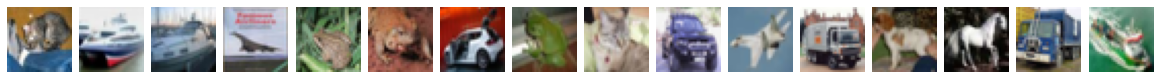

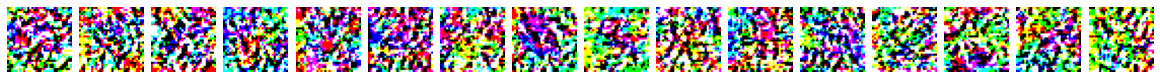

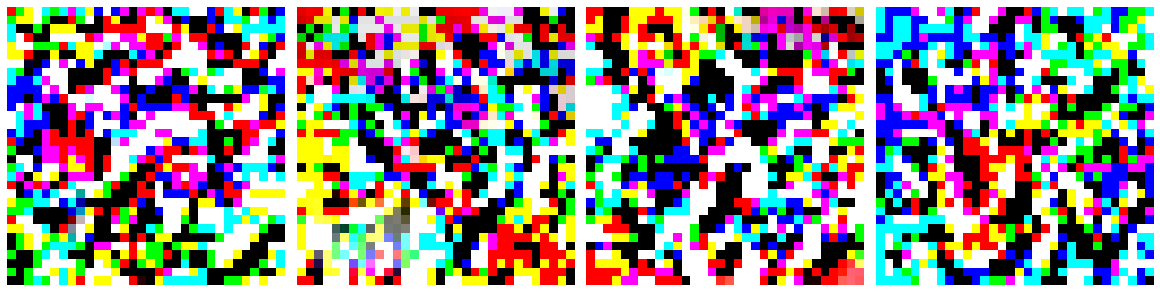

In [30]:
# score = model.evaluate(x_test, y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])


#model.load_weights('model.weights.best.hdf5')
pre_trained_model = tf.keras.models.load_model('model.weights.best.hdf5')

foolbox_model = foolbox.models.TensorFlowModel(model = pre_trained_model,bounds = (0.0, 1.0))
# FGSM
attack_fgsm = foolbox.attacks.FGSM()
epsilons = [
        0.0,
        0.0002,
        0.0005,
        0.0008,
        0.001,
        0.0015,
        0.002,
        0.003,
        0.01,
        0.1,
        0.3,
        0.5,
        1.0,
]

images, labels = ep.astensors(*foolbox.samples(foolbox_model, dataset="cifar10", batchsize=16)) # przyklad z githuba

# x_test = tf.convert_to_tensor(x_test, dtype=np.float32)
# y_test = tf.convert_to_tensor(y_test, dtype=np.int64)
# new_x_test, new_y_test = ep.astensors(x_test, y_test)

clean_acc = foolbox.accuracy(foolbox_model, images, labels)
print(f"clean accuracy:  {clean_acc * 100:.1f} %")

# atak jest wykonywany dla kazdego epsilona - wyjscie 13 roznych serii perturbacji kazda po 16 obrazkow
raw_advs, clipped_advs, success = attack_fgsm(foolbox_model, images, labels, epsilons=epsilons)

# print(raw_advs)
foolbox.plot.images(images)
foolbox.plot.images(raw_advs[12])
foolbox.plot.images(raw_advs[12] - images, n=4, bounds=(-0.1, 0.1), scale=4.)

# for i in range(1,3):
#     image = new_x_test[i]
#     _, advs, success = attack_fgsm(foolbox_model, image, new_y_test[i], epsilons=epsilons)
#     plt.imshow(np.squeeze(x_test[i]))
#     plt.show()
#     plt.imshow(np.squeeze(adversarial))

